# NN Model Training Notebook

This Jupyter Notebook serves as a documentation and workflow for training the NNClassifier ([MPLClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)).

## Data Processing

In the following cells, we import the necessary libraries and load the training and testing datasets. There are 2 variables that can be changed depending on the kind of dataset we want :
* `withOutliers` : True or False
* `data` : 'normal' | 'oversampled' | 'undersampled' 

NOTE : Make sure you already made the datasets with the commands:
- `make data`
- `make features`

We also perform data preprocessing steps such as encoding labels. Other preprocessing steps such as removing correlations with pca, and scaling the data are done within the pipeline of the model.



In [24]:
""" Import libraries """
import pandas as pd
import numpy as np
from src.models.NNClassifier import NNClassifier
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder

In [25]:
# Set the kind of data to use
withOutliers = True
data = 'oversampled' 

o = {True: "with", False: "without"}
d = {'normal': "", 'oversampled': "_over", 'undersampled': "_under"}

# Load train and test split
X_train = pd.read_csv(f'../data/processed/{o[withOutliers]}_outliers/train{d[data]}.csv')
y_train = X_train['class']
X_train = X_train.drop(['class'], axis=1)
X_test = pd.read_csv(f'../data/processed/{o[withOutliers]}_outliers/test.csv')
y_test = X_test['class']
X_test = X_test.drop(['class'], axis=1)

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

## Model Training

Once the data is processed, we proceed to train the model using hyperparameter tuning and cross validation to optimize performance. We use a [random search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) which is more efficient than a grid-search.

F1 score is choosen as the evaluation metric considering the scenarios where we use unbalanced data. F1 score provides a balance between precision and recall.

We try different number of hidden layers and neurons per layers and different kind of activation functions. 

For more detail about the influence of each parameter. Please refer to the [sklearn website](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

In [26]:
# Create the model
clf = NNClassifier()

# Choose the hyperparameters search space
parameters = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50),(100,100),(50,50,50),(100,50,100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': 10.0 ** -np.arange(1, 7),
    'batch_size': [100, 200, 300,'auto'],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 400, 600],
    'momentum': [0.9, 0.95, 0.99],
    'verbose': [False],
    'shuffle': [True,False],
    'early_stopping': [True,False],
    'validation_fraction': [0.1, 0.2, 0.3],
    'beta_1': [0.9, 0.95, 0.99],
    'beta_2': [0.9, 0.95, 0.99],
    'n_iter_no_change': [10, 20, 30],
}
# Perform the hyperparameter tuning with cross validation
clf.hyperparameter_tuning(X_train,y_train,parameters,search_type='random',cv=3,scoring='f1_macro',n_iteration=10)

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

In [30]:
print(f'Best parameters: {clf.best_params}')

Best parameters: {'model__verbose': False, 'model__validation_fraction': 0.1, 'model__solver': 'lbfgs', 'model__shuffle': True, 'model__n_iter_no_change': 20, 'model__momentum': 0.95, 'model__max_iter': 600, 'model__learning_rate_init': 0.001, 'model__learning_rate': 'constant', 'model__hidden_layer_sizes': (100,), 'model__early_stopping': False, 'model__beta_2': 0.95, 'model__beta_1': 0.9, 'model__batch_size': 200, 'model__alpha': 0.01, 'model__activation': 'relu'}


## Evaluation

Inference time : 1.369317372639974e-06 seconds
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     11621
           1       0.93      0.95      0.94      3740
           2       0.97      1.00      0.99      3839

    accuracy                           0.97     19200
   macro avg       0.96      0.97      0.97     19200
weighted avg       0.97      0.97      0.97     19200

auc score for class 0:  0.9930764901531877
auc score for class 1:  0.9927481995973739
auc score for class 2:  0.9986265085178737


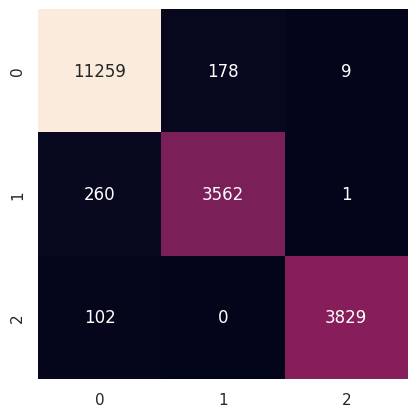

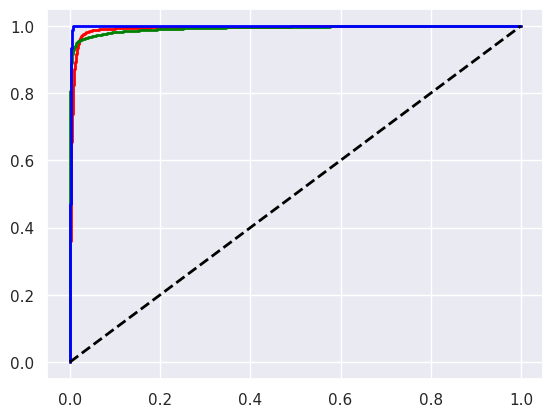

In [31]:
clf.evaluate(X_test,y_test)

## Saving the model

In [32]:
clf.save(new_name=f'nn_{o[withOutliers]}_outliers{d[data]}',path='../models/NN/')